The objective of this project is to **deploy a Flask app** that uses a model trained with the Fast.ai v2 library following an example (bear detector) in the upcoming book **"Deep Learning for Coders with fastai and PyTorch: AI Applications Without a PhD" by Jeremy Howard and Sylvain Gugger.**

The most important part of the project is **testing a deployment process that combines a Flask app, the Gunicorn server, the Nginx server and a custom domain name with an SSL certificate**, all installed on a dedicated server.

You can access the repo with all the code for this project plus detailed step by step explanations of how to deploy it, here:
**[Repo with code and details](https://github.com/javismiles/bear-detector-flask-deploy)**

Project put together by Javier Ideami (ideami.com)

In [0]:
#These lines are for google colab only, if you are on your own server, check the requirements.txt file at the repo.
#!pip install fastai2
#!pip install nbdev
#!pip install azure
#!pip install azure-cognitiveservices-vision-customvision
#!pip install azure-cognitiveservices-vision-computervision
#!pip install azure-cognitiveservices-search-websearch
#!pip install azure-cognitiveservices-search-imagesearch
#!unzip bearstotal.zip

In [0]:
from utils import *
from fastai2.vision.widgets import *
from fastai2.imports import *

In [0]:
# Categories of bears
bear_types = 'grizzly','black','teddy'
# Reference to the folder that holds the dataset
path = Path('bears')

In [0]:
# Get a reference to the images
fns = get_image_files(path)
fns

(#1896) [Path('bears/teddy/image24.jpeg'),Path('bears/teddy/images139.jpg'),Path('bears/teddy/images545.jpg'),Path('bears/teddy/images195.jpg'),Path('bears/teddy/giant-teddy-bear-1-meter-35.jpg'),Path('bears/teddy/images335.jpg'),Path('bears/teddy/images103.jpg'),Path('bears/teddy/images135.jpg'),Path('bears/teddy/images96.jpg'),Path('bears/teddy/images432.jpg')...]

In [0]:
# Check for images with problems (corrupted, etc)
failed = verify_images(fns)
failed

(#0) []

In [0]:
# You may delete images with issues with this command
#failed.map(Path.unlink);

In [0]:
# Create a datablock structure, composed of the independente variable (an image block), and the dependent variable (a category).
# The datablock will use the get_image_files function to get items, it will split randomly (but from the same seed always) the images using
# 30% of them for the validation set. It will assign the independent variable, the label by checking the parent of the image, the name of
# its parent folder. And it will resize each image to be 128x128 pixels
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [0]:
# Create a dataloader from the reference to the path of the dataset.
dls = bears.dataloaders(path)

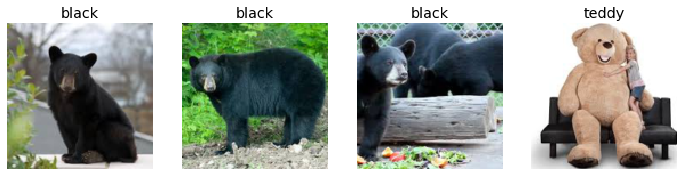

In [0]:
# Show 4 pictures of the validation set of the dataloader
dls.valid.show_batch(max_n=4, rows=1)

In [0]:
# Update the datablock, process each image, applying a random cropping process; also set the option of applying augmentation to
#batches of images; update the dataloader
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [0]:
# Create a cnn learner, passing it the dataloader, a resnet arquitecture reference, and setting the metric to evaluate to be the
# error rate
learn = cnn_learner(dls, resnet18, metrics=error_rate)
# We are doing transfer learning, to use fine_tune to fine tune the resnet during 4 epochs.
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.757225,0.196857,0.049296,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.215430,0.183540,0.049296,00:16
1,0.172765,0.197349,0.044014,00:15
2,0.150050,0.198652,0.044014,00:15
3,0.125362,0.182051,0.047535,00:15


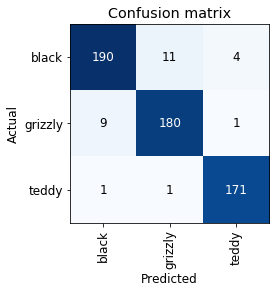

In [0]:
#Plot the confusion matrix to analyze the results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

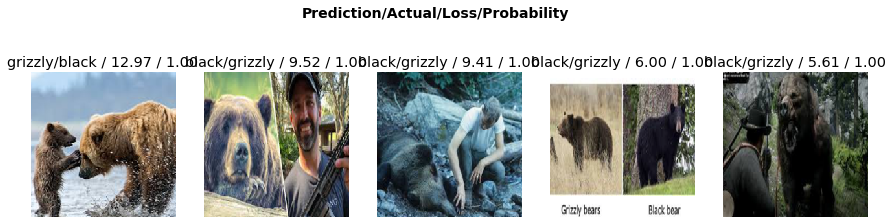

In [0]:
#Plot the top losses to analyze what kinds of images had issues
interp.plot_top_losses(5, rows=1)

In [0]:
#clean the dataset optionally to polish the training (ImageClassifierCleaner may work well in google colab)
#cleaner = ImageClassifierCleaner(learn)
#cleaner
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(cleaner.fns[idx], path/cat)

In [0]:
#This line will create a file (export.pkl), which you can then put in the "model" folder of the project to be used by the Flask app.
learn.export()